In [1]:
import torch
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from torchcam.methods import SmoothGradCAMpp
from PIL import Image
import os

In [2]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir caminho do modelo treinado
MODEL_PATH = "model/xception_deepfake.pth"
# Diretórios com as imagens
TEST_DIR = "teste/CELEB-DF/faces/Deepfake/id0_id26_0005"

In [3]:
# Carregar o modelo treinado
model = timm.create_model("xception41.tf_in1k", pretrained=False, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

XceptionAligned(
  (stem): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (stack): Sequential(
     

In [4]:
# Transformações para pré-processamento da imagem
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
# Função para encontrar a última camada convolucional
def get_last_conv_layer(model):
    last_conv_layer = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv_layer = name
    return last_conv_layer

# Obter a última camada convolucional
target_layer = get_last_conv_layer(model)
print(f"Camada alvo encontrada: {target_layer}")

Camada alvo encontrada: blocks.12.stack.conv3.conv_pw


In [6]:
# Função para carregar e pré-processar a imagem
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img, img_tensor.to(device)

In [7]:
# Função para gerar e sobrepor o mapa de calor
def generate_heatmap(model, img_tensor, original_img, target_layer):
    # Inicializar o método SmoothGradCAM++
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
    
    # Ativar gradientes para a entrada
    img_tensor.requires_grad_(True)
    
    # Forward pass para obter predição (sem no_grad para permitir gradientes)
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).item()
    
    # Gerar o mapa de calor
    activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    heatmap = activation_map[0].cpu().numpy()
    
    # Se o heatmap tiver múltiplos canais, reduzi-lo a um único canal (média ou soma)
    if len(heatmap.shape) == 3:  # Caso o heatmap tenha múltiplos canais (C, H, W)
        heatmap = np.mean(heatmap, axis=0)  # Média ao longo dos canais
    
    # Normalizar o mapa de calor
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-10)  # Adicionar pequena constante para evitar divisão por zero
    
    # Redimensionar para o tamanho da imagem original
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    
    # Garantir que o heatmap esteja no formato correto (escala de cinza, 8 bits)
    heatmap = np.uint8(255 * heatmap)
    
    # Aplicar o mapa de cores (deve ser CV_8UC1)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Sobrepor o mapa de calor na imagem original
    original_img_np = np.array(original_img)
    superimposed_img = heatmap_colored * 0.4 + original_img_np * 0.6
    superimposed_img = np.uint8(superimposed_img)
    
    return superimposed_img, pred

In [8]:
# Função principal para processar e visualizar resultados
def process_and_visualize(image_path, target_layer):
    original_img, img_tensor = load_image(image_path)
    result_img, prediction = generate_heatmap(model, img_tensor, original_img, target_layer)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Imagem Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_img)
    plt.title(f'Mapa de Calor - Predição: {"Fake" if prediction == 1 else "Real"}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Processando: teste/CELEB-DF/faces/Deepfake/id0_id26_0005/frame_235_face_0.jpg


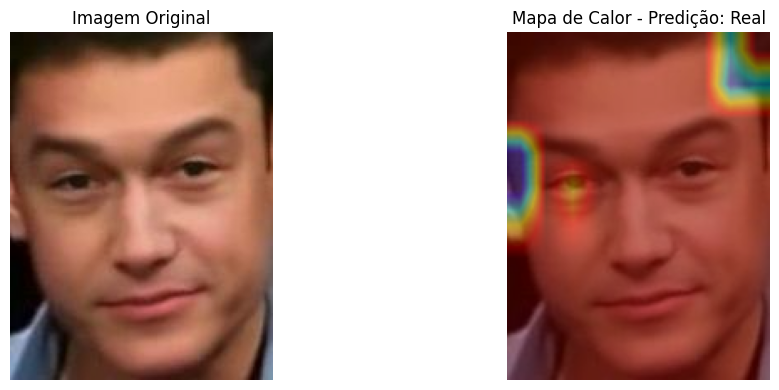

In [9]:
# Testar com uma imagem do diretório
if __name__ == "__main__":
    test_images = [f for f in os.listdir(TEST_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if test_images:
        test_image_path = os.path.join(TEST_DIR, test_images[0])
        print(f"Processando: {test_image_path}")
        process_and_visualize(test_image_path, target_layer)
    else:
        print("Nenhuma imagem encontrada no diretório especificado.")